# Time Series Exercise - 

### Follow along with the instructions in bold. Watch the solutions video if you get stuck!

## The Data

** Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line **

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

** Import numpy pandas and matplotlib **

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

** Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month' **

In [144]:
data = pd.read_csv('monthly-milk-production.csv',index_col='Month')

** Check out the head of the dataframe**

In [145]:
data.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


** Make the index a time series by using: **

    milk.index = pd.to_datetime(milk.index)

In [146]:
data.index = pd.to_datetime(data.index)

** Plot out the time series data. **

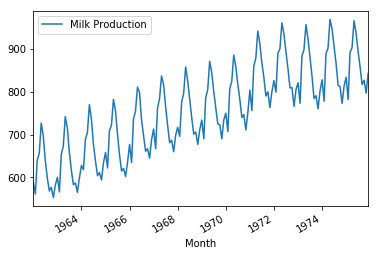

In [147]:
data.plot()

___

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **

** Create a test train split using indexing (hint: use .head() or tail() or .iloc[]). We don't want a random train test split, we want to specify that the test set is the last 12 months of data is the test set, with everything before it is the training. **

In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [149]:
train_set = data.head(156)

In [150]:
test_set = data.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [151]:
from sklearn.preprocessing import MinMaxScaler

In [152]:
sc = MinMaxScaler()

In [153]:
train_scaled = sc.fit_transform(train_set)

In [154]:
test_scaled = sc.transform(test_set)

## Batch Function

** We'll need a function that can feed batches of the training data. We'll need to do several things that are listed out as steps in the comments of the function. Remember to reference the previous batch method from the lecture for hints. Try to fill out the function template below, this is a pretty hard step, so feel free to reference the solutions! **

In [155]:
def next_batch(training_data,batch_size,steps):
    """
    INPUT: Data, Batch Size, Time Steps per batch
    OUTPUT: A tuple of y time series results. y[:,:-1] and y[:,1:]
    """
    
    # STEP 1: Use np.random.randint to set a random starting point index for the batch.
    # Remember that each batch needs have the same number of steps in it.
    # This means you should limit the starting point to len(data)-steps
    rand_start = np.random.randint(0,len(training_data) - steps)
    
    # STEP 2: Now that you have a starting index you'll need to index the data from
    # the random start to random start + steps + 1. Then reshape this data to be (1,steps+1)
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    # STEP 3: Return the batches. You'll have two batches to return y[:,:-1] and y[:,1:]
    # You'll need to reshape these into tensors for the RNN to .reshape(-1,steps,1)
    return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

## Setting Up The RNN Model

** Import TensorFlow **

In [156]:
import tensorflow as tf

### The Constants

** Define the constants in a single cell. You'll need the following (in parenthesis are the values I used in my solution, but you can play with some of these): **
* Number of Inputs (1)
* Number of Time Steps (12)
* Number of Neurons per Layer (100)
* Number of Outputs (1)
* Learning Rate (0.03)
* Number of Iterations for Training (4000)
* Batch Size (1)

In [157]:
num_inputs = 1
num_time_steps = 12
neurons_pre_layer = 100
num_outputs = 1
learning_rate = 0.001
train_iterations = 6000
batch_size = 1

** Create Placeholders for X and y. (You can change the variable names if you want). The shape for these placeholders should be [None,num_time_steps-1,num_inputs] and [None, num_time_steps-1, num_outputs] The reason we use num_time_steps-1 is because each of these will be one step shorter than the original time steps size, because we are training the RNN network to predict one point into the future based on the input sequence.**  

In [158]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

** Now create the RNN Layer, you have complete freedom over this, use tf.contrib.rnn and choose anything you want, OutputProjectionWrappers, BasicRNNCells, BasicLSTMCells, MultiRNNCell, GRUCell etc... Keep in mind not every combination will work well! (If in doubt, the solutions used an Outputprojection Wrapper around a basic LSTM cell with relu activation.**

In [159]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
            tf.contrib.rnn.GRUCell(neurons_pre_layer,activation=tf.nn.relu),output_size = num_outputs)

** Now pass in the cells variable into tf.nn.dynamic_rnn, along with your first placeholder (X)**

In [160]:
output, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

### Loss Function and Optimizer

** Create a Mean Squared Error Loss Function and use it to minimize an AdamOptimizer, remember to pass in your learning rate. **

In [161]:
loss = tf.reduce_mean(tf.square(output - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

** Initialize the global variables **

In [162]:
init = tf.global_variables_initializer()

** Create an instance of tf.train.Saver() **

In [163]:
saver = tf.train.Saver()

### Session

** Run a tf.Session that trains on the batches created by your next_batch function. Also add an a loss evaluation for every 100 training iterations. Remember to save your model after you are done training. **

In [164]:
with tf.Session() as sess:
    # CODE HERE!
    sess.run(init)
    
    for iteration in range(train_iterations):
        
        X_batch, y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        
        if iteration % 100 :
            
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,"MSE\t",mse)
    
    # Save Model for Later
    saver.save(sess, "./ex_time_series_model")

1 MSE	 0.0335083
2 MSE	 0.116195
3 MSE	 0.0546124
4 MSE	 0.0657399
5 MSE	 0.232066
6 MSE	 0.0881978
7 MSE	 0.151236
8 MSE	 0.270712
9 MSE	 0.0818674
10 MSE	 0.260032
11 MSE	 0.216364
12 MSE	 0.0620561
13 MSE	 0.202558
14 MSE	 0.0191365
15 MSE	 0.0342855
16 MSE	 0.10596
17 MSE	 0.0726635
18 MSE	 0.00998258
19 MSE	 0.149175
20 MSE	 0.0810181
21 MSE	 0.120365
22 MSE	 0.0654958
23 MSE	 0.00814872
24 MSE	 0.0673561
25 MSE	 0.0778484
26 MSE	 0.08184
27 MSE	 0.0519726
28 MSE	 0.0565128
29 MSE	 0.127264
30 MSE	 0.0490795
31 MSE	 0.0690659
32 MSE	 0.0519167
33 MSE	 0.0627957
34 MSE	 0.0663831
35 MSE	 0.0550385
36 MSE	 0.0374179
37 MSE	 0.0355019
38 MSE	 0.0426521
39 MSE	 0.0157569
40 MSE	 0.109557
41 MSE	 0.027626
42 MSE	 0.107436
43 MSE	 0.0778035
44 MSE	 0.0584508
45 MSE	 0.101117
46 MSE	 0.10222
47 MSE	 0.0433185
48 MSE	 0.0271672
49 MSE	 0.0896514
50 MSE	 0.039864
51 MSE	 0.0185159
52 MSE	 0.0295969
53 MSE	 0.0197711
54 MSE	 0.0194433
55 MSE	 0.0490386
56 MSE	 0.036278
57 MSE	 0.0301368
58 

444 MSE	 0.0226659
445 MSE	 0.00595854
446 MSE	 0.00920137
447 MSE	 0.00553404
448 MSE	 0.00805854
449 MSE	 0.0143312
450 MSE	 0.0114101
451 MSE	 0.0114983
452 MSE	 0.0126964
453 MSE	 0.00516478
454 MSE	 0.011248
455 MSE	 0.00884462
456 MSE	 0.0106141
457 MSE	 0.0199202
458 MSE	 0.0168258
459 MSE	 0.0112558
460 MSE	 0.00532756
461 MSE	 0.0174502
462 MSE	 0.0107809
463 MSE	 0.0284738
464 MSE	 0.0131152
465 MSE	 0.0118446
466 MSE	 0.0155282
467 MSE	 0.0127646
468 MSE	 0.00844982
469 MSE	 0.00874427
470 MSE	 0.0104812
471 MSE	 0.0124946
472 MSE	 0.0147256
473 MSE	 0.0100251
474 MSE	 0.00865407
475 MSE	 0.0114978
476 MSE	 0.012237
477 MSE	 0.0106466
478 MSE	 0.00861864
479 MSE	 0.00752835
480 MSE	 0.00789908
481 MSE	 0.0104848
482 MSE	 0.00992261
483 MSE	 0.0106215
484 MSE	 0.0151175
485 MSE	 0.0123399
486 MSE	 0.00658306
487 MSE	 0.0162247
488 MSE	 0.0133652
489 MSE	 0.0101566
490 MSE	 0.0112959
491 MSE	 0.00688718
492 MSE	 0.00673459
493 MSE	 0.0150815
494 MSE	 0.0150109
495 MSE	 0.02060

894 MSE	 0.00695814
895 MSE	 0.0120726
896 MSE	 0.00581715
897 MSE	 0.00929855
898 MSE	 0.0084217
899 MSE	 0.00705442
901 MSE	 0.0076468
902 MSE	 0.00830821
903 MSE	 0.00754072
904 MSE	 0.00939566
905 MSE	 0.0083814
906 MSE	 0.00891999
907 MSE	 0.00832659
908 MSE	 0.00633809
909 MSE	 0.0116696
910 MSE	 0.00656088
911 MSE	 0.00976505
912 MSE	 0.0080746
913 MSE	 0.00859309
914 MSE	 0.00996254
915 MSE	 0.0121722
916 MSE	 0.00845661
917 MSE	 0.00679855
918 MSE	 0.00839828
919 MSE	 0.00634599
920 MSE	 0.0068978
921 MSE	 0.009505
922 MSE	 0.0118776
923 MSE	 0.00998189
924 MSE	 0.00846527
925 MSE	 0.00638276
926 MSE	 0.00713639
927 MSE	 0.0155565
928 MSE	 0.00759594
929 MSE	 0.0103668
930 MSE	 0.00887991
931 MSE	 0.00878248
932 MSE	 0.00764471
933 MSE	 0.00781966
934 MSE	 0.00622942
935 MSE	 0.00960983
936 MSE	 0.0091574
937 MSE	 0.0080363
938 MSE	 0.00865859
939 MSE	 0.0142866
940 MSE	 0.00755706
941 MSE	 0.00974969
942 MSE	 0.00792556
943 MSE	 0.00939392
944 MSE	 0.0094248
945 MSE	 0.005720

1325 MSE	 0.00592592
1326 MSE	 0.00807815
1327 MSE	 0.00823463
1328 MSE	 0.0104213
1329 MSE	 0.00871865
1330 MSE	 0.0101874
1331 MSE	 0.0145352
1332 MSE	 0.00575583
1333 MSE	 0.00989613
1334 MSE	 0.00687488
1335 MSE	 0.0103161
1336 MSE	 0.00966154
1337 MSE	 0.00749566
1338 MSE	 0.00737993
1339 MSE	 0.0105319
1340 MSE	 0.00987652
1341 MSE	 0.00797411
1342 MSE	 0.0076028
1343 MSE	 0.00799163
1344 MSE	 0.00814056
1345 MSE	 0.0078083
1346 MSE	 0.00721423
1347 MSE	 0.00842543
1348 MSE	 0.00460301
1349 MSE	 0.00875642
1350 MSE	 0.0103309
1351 MSE	 0.0095853
1352 MSE	 0.00464244
1353 MSE	 0.00989475
1354 MSE	 0.0094664
1355 MSE	 0.00897021
1356 MSE	 0.00758051
1357 MSE	 0.00795117
1358 MSE	 0.011635
1359 MSE	 0.00848113
1360 MSE	 0.0108068
1361 MSE	 0.00964801
1362 MSE	 0.00763167
1363 MSE	 0.00839193
1364 MSE	 0.00799203
1365 MSE	 0.0100155
1366 MSE	 0.00651713
1367 MSE	 0.00712176
1368 MSE	 0.0101539
1369 MSE	 0.00826144
1370 MSE	 0.00764352
1371 MSE	 0.00746379
1372 MSE	 0.00669289
1373 MS

1725 MSE	 0.00756387
1726 MSE	 0.00722963
1727 MSE	 0.00699669
1728 MSE	 0.00538819
1729 MSE	 0.0050143
1730 MSE	 0.0065215
1731 MSE	 0.00498006
1732 MSE	 0.00579602
1733 MSE	 0.00729707
1734 MSE	 0.0062551
1735 MSE	 0.00409336
1736 MSE	 0.00546996
1737 MSE	 0.0134207
1738 MSE	 0.00630969
1739 MSE	 0.00632291
1740 MSE	 0.00728298
1741 MSE	 0.00707911
1742 MSE	 0.00453762
1743 MSE	 0.00700193
1744 MSE	 0.00597742
1745 MSE	 0.00927218
1746 MSE	 0.00610868
1747 MSE	 0.00637992
1748 MSE	 0.0123061
1749 MSE	 0.00759743
1750 MSE	 0.00526449
1751 MSE	 0.00815756
1752 MSE	 0.00833109
1753 MSE	 0.0084736
1754 MSE	 0.00639343
1755 MSE	 0.0107267
1756 MSE	 0.00816799
1757 MSE	 0.00580977
1758 MSE	 0.00809646
1759 MSE	 0.00640877
1760 MSE	 0.00558936
1761 MSE	 0.00559732
1762 MSE	 0.00949985
1763 MSE	 0.00654641
1764 MSE	 0.00605772
1765 MSE	 0.0049899
1766 MSE	 0.0111632
1767 MSE	 0.00627615
1768 MSE	 0.00979335
1769 MSE	 0.00775004
1770 MSE	 0.00805857
1771 MSE	 0.00747204
1772 MSE	 0.00554228
1

2144 MSE	 0.00675726
2145 MSE	 0.00624182
2146 MSE	 0.00534919
2147 MSE	 0.00450717
2148 MSE	 0.00691651
2149 MSE	 0.00861228
2150 MSE	 0.00547906
2151 MSE	 0.00876464
2152 MSE	 0.00996952
2153 MSE	 0.00791988
2154 MSE	 0.00339189
2155 MSE	 0.00536829
2156 MSE	 0.00360316
2157 MSE	 0.00752619
2158 MSE	 0.00567753
2159 MSE	 0.00446206
2160 MSE	 0.00496897
2161 MSE	 0.0116926
2162 MSE	 0.00580981
2163 MSE	 0.00795249
2164 MSE	 0.00431009
2165 MSE	 0.00505011
2166 MSE	 0.0078924
2167 MSE	 0.00706714
2168 MSE	 0.00674183
2169 MSE	 0.00922183
2170 MSE	 0.00529622
2171 MSE	 0.00791337
2172 MSE	 0.00988378
2173 MSE	 0.00575763
2174 MSE	 0.00257908
2175 MSE	 0.00633282
2176 MSE	 0.00523763
2177 MSE	 0.00803939
2178 MSE	 0.0064042
2179 MSE	 0.00709979
2180 MSE	 0.00463975
2181 MSE	 0.00405123
2182 MSE	 0.00256935
2183 MSE	 0.00506756
2184 MSE	 0.0103689
2185 MSE	 0.00425986
2186 MSE	 0.00361037
2187 MSE	 0.0107317
2188 MSE	 0.00293172
2189 MSE	 0.0100803
2190 MSE	 0.00359729
2191 MSE	 0.0053365

2565 MSE	 0.00907733
2566 MSE	 0.00446763
2567 MSE	 0.00820184
2568 MSE	 0.00245646
2569 MSE	 0.00462811
2570 MSE	 0.00659517
2571 MSE	 0.00565416
2572 MSE	 0.00626775
2573 MSE	 0.0104829
2574 MSE	 0.00609452
2575 MSE	 0.00448343
2576 MSE	 0.00504931
2577 MSE	 0.0102597
2578 MSE	 0.00733744
2579 MSE	 0.00430534
2580 MSE	 0.00514813
2581 MSE	 0.00394504
2582 MSE	 0.00522848
2583 MSE	 0.00443746
2584 MSE	 0.00843469
2585 MSE	 0.00444861
2586 MSE	 0.0026154
2587 MSE	 0.00794822
2588 MSE	 0.00942751
2589 MSE	 0.00753381
2590 MSE	 0.00904353
2591 MSE	 0.00633316
2592 MSE	 0.00562912
2593 MSE	 0.00562395
2594 MSE	 0.00395215
2595 MSE	 0.00522977
2596 MSE	 0.0039347
2597 MSE	 0.00486341
2598 MSE	 0.00838513
2599 MSE	 0.00374099
2601 MSE	 0.00364714
2602 MSE	 0.00593646
2603 MSE	 0.00691623
2604 MSE	 0.00675835
2605 MSE	 0.00429891
2606 MSE	 0.00833434
2607 MSE	 0.00503607
2608 MSE	 0.00467131
2609 MSE	 0.00217053
2610 MSE	 0.00727909
2611 MSE	 0.00396224
2612 MSE	 0.0069558
2613 MSE	 0.005071

2990 MSE	 0.0057453
2991 MSE	 0.00611881
2992 MSE	 0.00684369
2993 MSE	 0.00887332
2994 MSE	 0.00614051
2995 MSE	 0.0105613
2996 MSE	 0.00661736
2997 MSE	 0.00619042
2998 MSE	 0.00478155
2999 MSE	 0.0055216
3001 MSE	 0.00409154
3002 MSE	 0.00523244
3003 MSE	 0.00265964
3004 MSE	 0.00382274
3005 MSE	 0.00877137
3006 MSE	 0.00714683
3007 MSE	 0.00415942
3008 MSE	 0.00248576
3009 MSE	 0.00495299
3010 MSE	 0.0075487
3011 MSE	 0.00681146
3012 MSE	 0.0085566
3013 MSE	 0.0049868
3014 MSE	 0.00900522
3015 MSE	 0.00536908
3016 MSE	 0.00759735
3017 MSE	 0.00388017
3018 MSE	 0.00672467
3019 MSE	 0.00629534
3020 MSE	 0.00568933
3021 MSE	 0.00635944
3022 MSE	 0.00819604
3023 MSE	 0.00483499
3024 MSE	 0.00358037
3025 MSE	 0.00649209
3026 MSE	 0.00197512
3027 MSE	 0.00425623
3028 MSE	 0.00627287
3029 MSE	 0.00523867
3030 MSE	 0.00446065
3031 MSE	 0.004489
3032 MSE	 0.00380934
3033 MSE	 0.00635041
3034 MSE	 0.00274294
3035 MSE	 0.00991147
3036 MSE	 0.00433588
3037 MSE	 0.00438058
3038 MSE	 0.00465682


3390 MSE	 0.0115703
3391 MSE	 0.00179939
3392 MSE	 0.00586413
3393 MSE	 0.00415962
3394 MSE	 0.00635663
3395 MSE	 0.00569869
3396 MSE	 0.00477886
3397 MSE	 0.00406867
3398 MSE	 0.00357907
3399 MSE	 0.00421641
3401 MSE	 0.00463922
3402 MSE	 0.00575151
3403 MSE	 0.00225872
3404 MSE	 0.00304417
3405 MSE	 0.00526069
3406 MSE	 0.00530481
3407 MSE	 0.00960012
3408 MSE	 0.00286038
3409 MSE	 0.00456995
3410 MSE	 0.00679041
3411 MSE	 0.00450082
3412 MSE	 0.00669612
3413 MSE	 0.00555227
3414 MSE	 0.00278434
3415 MSE	 0.00606869
3416 MSE	 0.00454355
3417 MSE	 0.0045804
3418 MSE	 0.00352541
3419 MSE	 0.00499856
3420 MSE	 0.00287247
3421 MSE	 0.00534137
3422 MSE	 0.00281034
3423 MSE	 0.0079169
3424 MSE	 0.00507776
3425 MSE	 0.00600131
3426 MSE	 0.00469523
3427 MSE	 0.00590234
3428 MSE	 0.00486773
3429 MSE	 0.0095892
3430 MSE	 0.00510605
3431 MSE	 0.00245305
3432 MSE	 0.0105807
3433 MSE	 0.00273943
3434 MSE	 0.0035098
3435 MSE	 0.00518794
3436 MSE	 0.0058831
3437 MSE	 0.00825289
3438 MSE	 0.00549221

3795 MSE	 0.00761925
3796 MSE	 0.00839947
3797 MSE	 0.00296439
3798 MSE	 0.00213689
3799 MSE	 0.0038947
3801 MSE	 0.00614621
3802 MSE	 0.0113287
3803 MSE	 0.00623093
3804 MSE	 0.00642468
3805 MSE	 0.00433476
3806 MSE	 0.00448295
3807 MSE	 0.00315583
3808 MSE	 0.00856725
3809 MSE	 0.00527044
3810 MSE	 0.00491249
3811 MSE	 0.00274375
3812 MSE	 0.00636293
3813 MSE	 0.00354439
3814 MSE	 0.00464505
3815 MSE	 0.00362833
3816 MSE	 0.00385582
3817 MSE	 0.00829822
3818 MSE	 0.00749212
3819 MSE	 0.00845314
3820 MSE	 0.00672609
3821 MSE	 0.00790779
3822 MSE	 0.00614759
3823 MSE	 0.00227834
3824 MSE	 0.00467412
3825 MSE	 0.00280815
3826 MSE	 0.00382178
3827 MSE	 0.00409177
3828 MSE	 0.00941264
3829 MSE	 0.00839561
3830 MSE	 0.00525776
3831 MSE	 0.0083255
3832 MSE	 0.00280961
3833 MSE	 0.00793962
3834 MSE	 0.00479591
3835 MSE	 0.00620448
3836 MSE	 0.00368011
3837 MSE	 0.00364651
3838 MSE	 0.00743799
3839 MSE	 0.00387388
3840 MSE	 0.00671371
3841 MSE	 0.00532617
3842 MSE	 0.00169869
3843 MSE	 0.0050

4216 MSE	 0.00297431
4217 MSE	 0.0024699
4218 MSE	 0.0077417
4219 MSE	 0.00467014
4220 MSE	 0.005521
4221 MSE	 0.00154038
4222 MSE	 0.00365971
4223 MSE	 0.00563727
4224 MSE	 0.00512183
4225 MSE	 0.00214985
4226 MSE	 0.00138396
4227 MSE	 0.00211393
4228 MSE	 0.00432195
4229 MSE	 0.00589519
4230 MSE	 0.00578194
4231 MSE	 0.00476169
4232 MSE	 0.00158006
4233 MSE	 0.00350254
4234 MSE	 0.00939018
4235 MSE	 0.00466923
4236 MSE	 0.00147461
4237 MSE	 0.00503525
4238 MSE	 0.00218451
4239 MSE	 0.00481472
4240 MSE	 0.00585493
4241 MSE	 0.0012757
4242 MSE	 0.00292501
4243 MSE	 0.00260208
4244 MSE	 0.00408401
4245 MSE	 0.00535609
4246 MSE	 0.00368543
4247 MSE	 0.00334268
4248 MSE	 0.0051814
4249 MSE	 0.0147149
4250 MSE	 0.00467266
4251 MSE	 0.00381874
4252 MSE	 0.00245854
4253 MSE	 0.00171329
4254 MSE	 0.00365586
4255 MSE	 0.00323985
4256 MSE	 0.00260188
4257 MSE	 0.00268924
4258 MSE	 0.00920649
4259 MSE	 0.0033735
4260 MSE	 0.00328447
4261 MSE	 0.0015945
4262 MSE	 0.00174734
4263 MSE	 0.00531017
4

4629 MSE	 0.00435514
4630 MSE	 0.00427915
4631 MSE	 0.00947256
4632 MSE	 0.00433519
4633 MSE	 0.00298347
4634 MSE	 0.0029038
4635 MSE	 0.00389746
4636 MSE	 0.00374363
4637 MSE	 0.00305544
4638 MSE	 0.00584061
4639 MSE	 0.00440718
4640 MSE	 0.0124451
4641 MSE	 0.00247741
4642 MSE	 0.00209612
4643 MSE	 0.00245816
4644 MSE	 0.00512579
4645 MSE	 0.00242675
4646 MSE	 0.00229665
4647 MSE	 0.0033516
4648 MSE	 0.00345969
4649 MSE	 0.00503813
4650 MSE	 0.00360681
4651 MSE	 0.00508837
4652 MSE	 0.00850687
4653 MSE	 0.0046605
4654 MSE	 0.00345158
4655 MSE	 0.00628385
4656 MSE	 0.00517364
4657 MSE	 0.00361371
4658 MSE	 0.00523775
4659 MSE	 0.0094864
4660 MSE	 0.00808595
4661 MSE	 0.0055502
4662 MSE	 0.00349172
4663 MSE	 0.00191271
4664 MSE	 0.0058157
4665 MSE	 0.0038718
4666 MSE	 0.00180773
4667 MSE	 0.00487188
4668 MSE	 0.00815403
4669 MSE	 0.00419454
4670 MSE	 0.00695089
4671 MSE	 0.00690892
4672 MSE	 0.00421867
4673 MSE	 0.00366759
4674 MSE	 0.00236978
4675 MSE	 0.00379144
4676 MSE	 0.00599619


5037 MSE	 0.00438005
5038 MSE	 0.0038688
5039 MSE	 0.00759898
5040 MSE	 0.00997991
5041 MSE	 0.00421887
5042 MSE	 0.00482754
5043 MSE	 0.00357588
5044 MSE	 0.00354601
5045 MSE	 0.00411601
5046 MSE	 0.00414611
5047 MSE	 0.00927096
5048 MSE	 0.00490177
5049 MSE	 0.00655233
5050 MSE	 0.00235202
5051 MSE	 0.00849599
5052 MSE	 0.00337448
5053 MSE	 0.0034365
5054 MSE	 0.00507209
5055 MSE	 0.0056369
5056 MSE	 0.00320285
5057 MSE	 0.00365528
5058 MSE	 0.00513117
5059 MSE	 0.00412919
5060 MSE	 0.00526737
5061 MSE	 0.00349384
5062 MSE	 0.00717885
5063 MSE	 0.00914921
5064 MSE	 0.00435612
5065 MSE	 0.004394
5066 MSE	 0.00330338
5067 MSE	 0.00485466
5068 MSE	 0.00194368
5069 MSE	 0.00352254
5070 MSE	 0.00515566
5071 MSE	 0.00659481
5072 MSE	 0.00231382
5073 MSE	 0.00273975
5074 MSE	 0.003192
5075 MSE	 0.00632958
5076 MSE	 0.0018362
5077 MSE	 0.00544525
5078 MSE	 0.00365035
5079 MSE	 0.00578141
5080 MSE	 0.00235764
5081 MSE	 0.0049661
5082 MSE	 0.00208019
5083 MSE	 0.00361016
5084 MSE	 0.00721668
5

5440 MSE	 0.00687984
5441 MSE	 0.00459144
5442 MSE	 0.00495296
5443 MSE	 0.00500911
5444 MSE	 0.00426094
5445 MSE	 0.00258373
5446 MSE	 0.00411856
5447 MSE	 0.00285509
5448 MSE	 0.00532907
5449 MSE	 0.00472041
5450 MSE	 0.00433203
5451 MSE	 0.00480006
5452 MSE	 0.00443931
5453 MSE	 0.00434137
5454 MSE	 0.00364083
5455 MSE	 0.00389733
5456 MSE	 0.00283606
5457 MSE	 0.00366554
5458 MSE	 0.0057668
5459 MSE	 0.00332771
5460 MSE	 0.000629789
5461 MSE	 0.00461349
5462 MSE	 0.00820628
5463 MSE	 0.00671407
5464 MSE	 0.00845473
5465 MSE	 0.0058486
5466 MSE	 0.00510368
5467 MSE	 0.00769085
5468 MSE	 0.00434057
5469 MSE	 0.00402396
5470 MSE	 0.00251447
5471 MSE	 0.00621509
5472 MSE	 0.00376193
5473 MSE	 0.00800817
5474 MSE	 0.0021798
5475 MSE	 0.00131819
5476 MSE	 0.00500578
5477 MSE	 0.00463973
5478 MSE	 0.00375209
5479 MSE	 0.002773
5480 MSE	 0.00422308
5481 MSE	 0.0012222
5482 MSE	 0.00308766
5483 MSE	 0.00529948
5484 MSE	 0.00345252
5485 MSE	 0.00427555
5486 MSE	 0.00993154
5487 MSE	 0.003374

5853 MSE	 0.0059378
5854 MSE	 0.00321612
5855 MSE	 0.0086129
5856 MSE	 0.00275746
5857 MSE	 0.00187369
5858 MSE	 0.00244496
5859 MSE	 0.00348032
5860 MSE	 0.00377944
5861 MSE	 0.011715
5862 MSE	 0.010322
5863 MSE	 0.00452091
5864 MSE	 0.00240134
5865 MSE	 0.0029327
5866 MSE	 0.00699931
5867 MSE	 0.00598393
5868 MSE	 0.00759048
5869 MSE	 0.00542661
5870 MSE	 0.00225026
5871 MSE	 0.0024207
5872 MSE	 0.00570099
5873 MSE	 0.00497758
5874 MSE	 0.00405608
5875 MSE	 0.00676084
5876 MSE	 0.00563817
5877 MSE	 0.00616493
5878 MSE	 0.00582453
5879 MSE	 0.00459327
5880 MSE	 0.00641288
5881 MSE	 0.00541389
5882 MSE	 0.0103555
5883 MSE	 0.00156898
5884 MSE	 0.00231466
5885 MSE	 0.00380656
5886 MSE	 0.00337146
5887 MSE	 0.0023928
5888 MSE	 0.00429863
5889 MSE	 0.00516416
5890 MSE	 0.00205381
5891 MSE	 0.00525974
5892 MSE	 0.00162564
5893 MSE	 0.0067445
5894 MSE	 0.00146329
5895 MSE	 0.0031181
5896 MSE	 0.0066026
5897 MSE	 0.00364843
5898 MSE	 0.00182111
5899 MSE	 0.00423752
5901 MSE	 0.00527692
5902 

______

## Predicting Future (Test Data)

** Show the test_set (the last 12 months of your original complete data set) **

In [165]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


** Now we want to attempt to predict these 12 months of data, using only the training data we had. To do this we will feed in a seed training_instance of the last 12 months of the training_set of data to predict 12 months into the future. Then we will be able to compare our generated 12 months to our actual true historical values from the test set! **

# Generative Session
### NOTE: Recall that our model is really only trained to predict 1 time step ahead, asking it to generate 12 steps is a big ask, and technically not what it was trained to do! Think of this more as generating new values based off some previous pattern, rather than trying to directly predict the future. You would need to go back to the original model and train the model to predict 12 time steps ahead to really get a higher accuracy on the test data. (Which has its limits due to the smaller size of our data set)
** Fill out the session code below to generate 12 months of data based off the last 12 months of data from the training set. The hardest part about this is adjusting the arrays with their shapes and sizes. Reference the lecture for hints.**

In [166]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./ex_time_series_model")
    
    train_seed = list(train_scaled[-12:])
    
    for iteration in range(12):
        
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(output,feed_dict={X:X_batch})
        
        train_seed.append(y_pred[0,-1,0])
    # CODE HERE!

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


** Show the result of the predictions. **

In [167]:
train_seed

[array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.68732262,
 0.59001148,
 0.82486981,
 0.89533383,
 1.0472679,
 0.98992115,
 0.85752559,
 0.75593793,
 0.64016306,
 0.62568748,
 0.55712956,
 0.64211434]

** Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.**

In [168]:
results = sc.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

** Create a new column on the test_set called "Generated" and set it equal to the generated results. You may get a warning about this, feel free to ignore it.**

In [169]:
test_set["Generated"] = results

C:\Users\LENOVO\Anaconda31\envs\tfdeeplearning\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


** View the test_set dataframe. **

In [170]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,838.926208
1975-02-01 01:00:00,782.0,798.444763
1975-03-01 01:00:00,892.0,896.145874
1975-04-01 01:00:00,903.0,925.458801
1975-05-01 01:00:00,966.0,988.663452
1975-06-01 01:00:00,937.0,964.807129
1975-07-01 01:00:00,896.0,909.730591
1975-08-01 01:00:00,858.0,867.470215
1975-09-01 01:00:00,817.0,819.307800


** Plot out the two columns for comparison. **

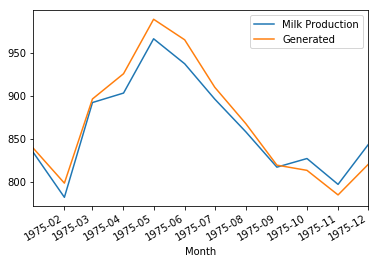

In [171]:
test_set.plot()

# Great Job!

Play around with the parameters and RNN layers, does a faster learning rate with more steps improve the model? What about GRU or BasicRNN units? What if you train the original model to not just predict one timestep ahead into the future, but 3 instead? Lots of stuff to add on here!